In [1]:
from glob import glob
import numpy as np
import pyabf
import matplotlib.pyplot as plt
import matplotlib as mp
from open_abf import *
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.optimize import leastsq
%matplotlib widget

In [2]:
pathToData = "/home/alan/Documents/LAB/CSHL/Data/Jiajia_Freeday/"
files = glob(pathToData+"*.abf")
files

['/home/alan/Documents/LAB/CSHL/Data/Jiajia_Freeday/2024_06_21_0011.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Jiajia_Freeday/2024_06_21_0001.abf']

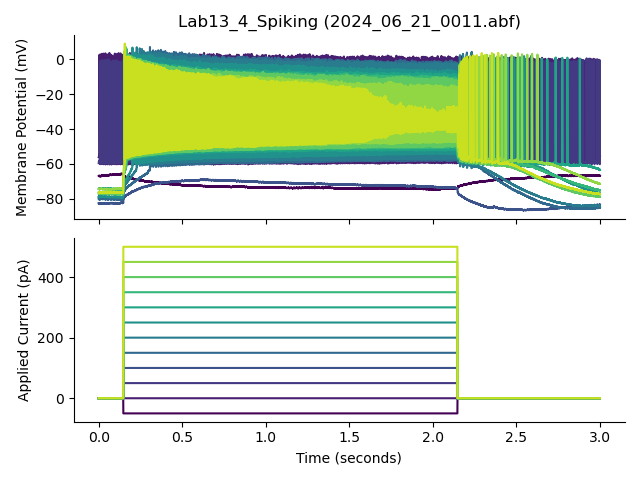

In [3]:
plt.close('all')
f = files[0]
plot_swps(f)

In [6]:
## Extract the sweeps
swps, swp_time, sr = get_sweeps(f)
## The mean on your current step:
i_start = 0.5
i_end = 1
current_step = np.mean(swp_window(swps,i_start,i_end,sr,channel=1),axis=1)
## The spiking part:
v_start = 0.5
v_end = 2
voltage = swp_window(swps,v_start,v_end,sr,channel=0)

In [51]:

def kernel(dx, sigma):
    return np.exp(-dx**2/(2*sigma**2))


def smooth(x, sigma, ydata, xdata=None):
    x = np.array(x)
    if xdata is None:
        assert len(x)==np.array(ydata).shape[-1]
        xdata = x
    k = kernel(xdata[:,None]-x[None,:], sigma)
    ydim = np.array(ydata).ndim
    new_shape_k = tuple([1]*(ydim-1)) + k.shape
    k = np.reshape(k,new_shape_k)
    y = (k*ydata[...,None]).sum(-2)/k.sum(-2)
    return y
    
def spike_detect(volt, v_dt,
                 thr=-10, inf_bnd=3, sup_bnd=500,
                 ref_t=1e-3):
    deriv = np.diff(volt)
    is_spk = (deriv[:-1]<2) * (deriv[1:]>=2)
    spikes = np.where(is_spk)[0]
    refact = int(ref_t/v_dt)
    ref = 0
    sspk = []
    for st in spikes:
        if st<ref:
            continue
        else:
            spk = volt[st:st+refact]
        if spk.max() < thr:
            continue
        else:
            sspk.append(st)
            ref = st+refact
    sspk = np.array(sspk)
    stimes = sspk*v_dt
    isi = np.diff(stimes)
    inst_frq = 1/isi
    if sspk.shape == (0,):
        return None
    else:
        return np.mean(inst_frq)

In [52]:
res = []
for v in voltage:
    res.append(spike_detect(v,1/sr))

In [53]:
res

[None,
 94.29423773514478,
 113.71065392261097,
 None,
 113.48655349999947,
 133.6670859565248,
 148.69568534459796,
 163.15791850203883,
 167.15735117092316,
 168.51315987630656,
 166.5800122254809,
 173.8307650431256]

Text(0, 0.5, 'Spiking frequency (Hz)')

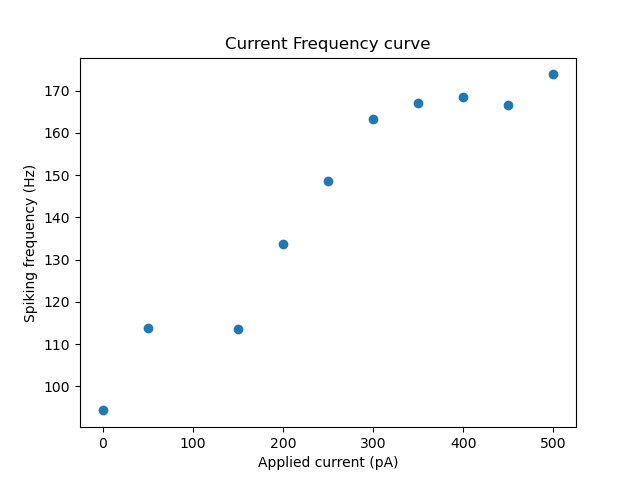

In [56]:
fig,ax = plt.subplots()
ax.set_title('Current Frequency curve')
ax.plot(current_step,res,'o')
ax.set_xlabel('Applied current (pA)')
ax.set_ylabel('Spiking frequency (Hz)')

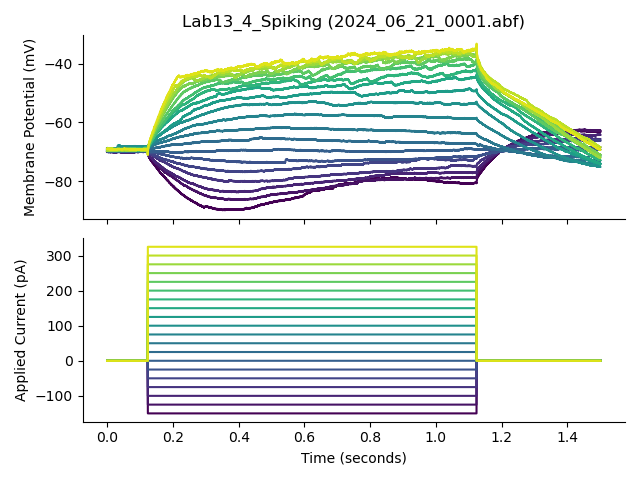

In [57]:
plt.close('all')
f = files[1]
plot_swps(f)

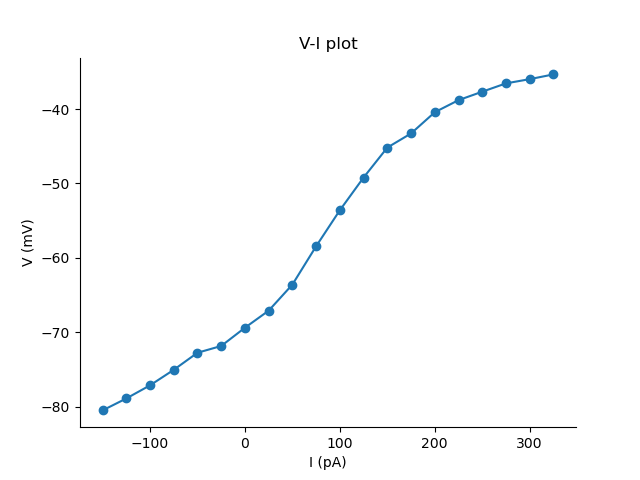

In [60]:
## Extract the sweeps
swps, swp_time, sr = get_sweeps(f)
## The mean on your current step:
i_start = 0.2
i_end = 1
current_step = np.mean(swp_window(swps,i_start,i_end,sr,channel=1),axis=1)
## The spiking part:
v_start = 1
v_end = 1.1
voltage = np.mean(swp_window(swps,v_start,v_end,sr,channel=0),axis=1)
fig,ax = plt.subplots()
ax.set_title('V-I plot')
ax.plot(current_step,voltage,'-o')
ax.set_ylabel('V (mV)')
ax.set_xlabel('I (pA)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()